In [ ]:
from fastcore.all import *
import sys
sys.path.append("..")
import wandb
from fastcore import test
import pandas as pd
import numpy as np
from timecluster_extension.load import *
from timecluster_extension.dr import *
from timecluster_extension.visualization import *
from tensorflow.keras.optimizers import Adam
import wandb
from wandb.keras import WandbCallback
from yaml import load, FullLoader
from fastcore.utils import Path
from datetime import datetime
import pickle
import matplotlib.pyplot as plt


# Comparison between datasets

> This notebook tries to show the statistical differences between datasets used during training, validation and testing of models in this project.


Load a wandb run

In [ ]:
run_wandb = wandb.init(entity = "pacmel",
                      project="timecluster-extension",
                      job_type='train_DCAE',
                      allow_val_change=True,
                      resume=False)
config = wandb.config 

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: pacmel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Load artifacts:

In [ ]:
artifact_train = 'JNK:train_18days'
artifact_validation = 'JNK:validation_2days'
artifact_test = 'JNK:test_2days'

In [ ]:
# Get data as artifact
ds_train_artifact = run_wandb.use_artifact(artifact_train)
ds_validation_artifact = run_wandb.use_artifact(artifact_validation)
ds_test_artifact = run_wandb.use_artifact(artifact_test)
# Get data as Pandas Dataframe
df_train = ds_train_artifact.to_df()
df_validation = ds_validation_artifact.to_df()
df_test = ds_test_artifact.to_df()

In [ ]:
# Code taken from 
def show_heatmap(data, plot_title, figsize=(5,5)):
    "Function to plot correlation between variables. Code taken from \
     https://keras.io/examples/timeseries/timeseries_weather_forecasting"
    plt.figure(figsize=(figsize[0],figsize[1]))
    plt.matshow(data.corr(), fignum=1)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(plot_title, fontsize=14)
    plt.show()

## Correlation between variables of dataset

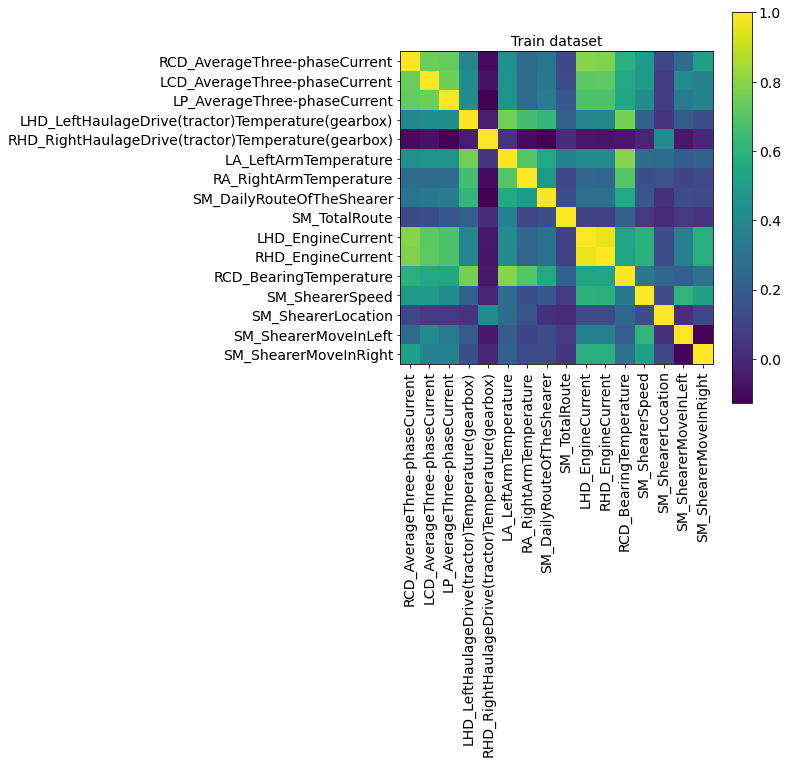

In [ ]:
show_heatmap(df_train, plot_title = "Train dataset", figsize=(7,7))

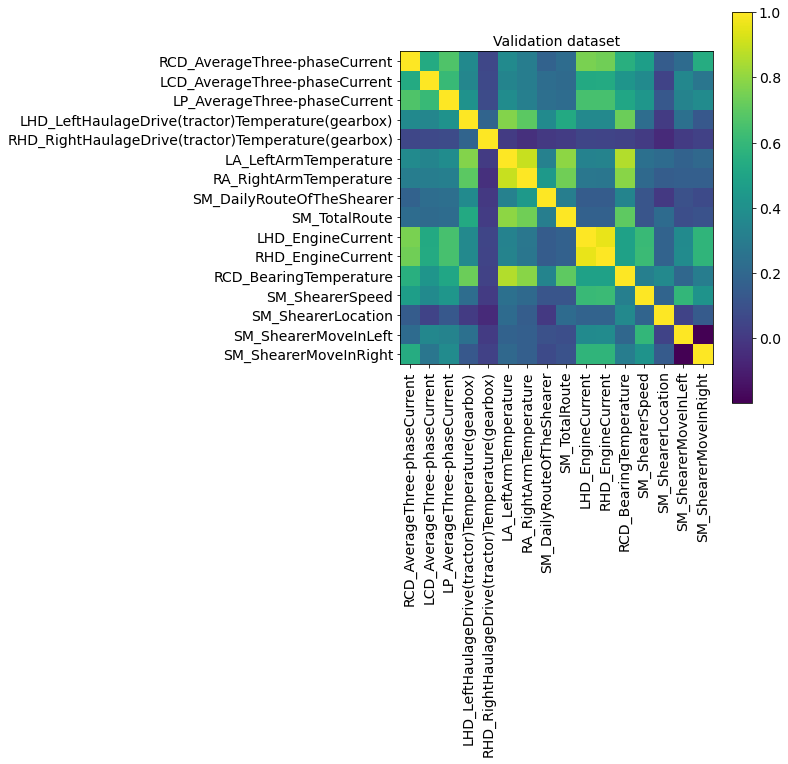

In [ ]:
show_heatmap(df_validation, plot_title = "Validation dataset", figsize=(7,7))

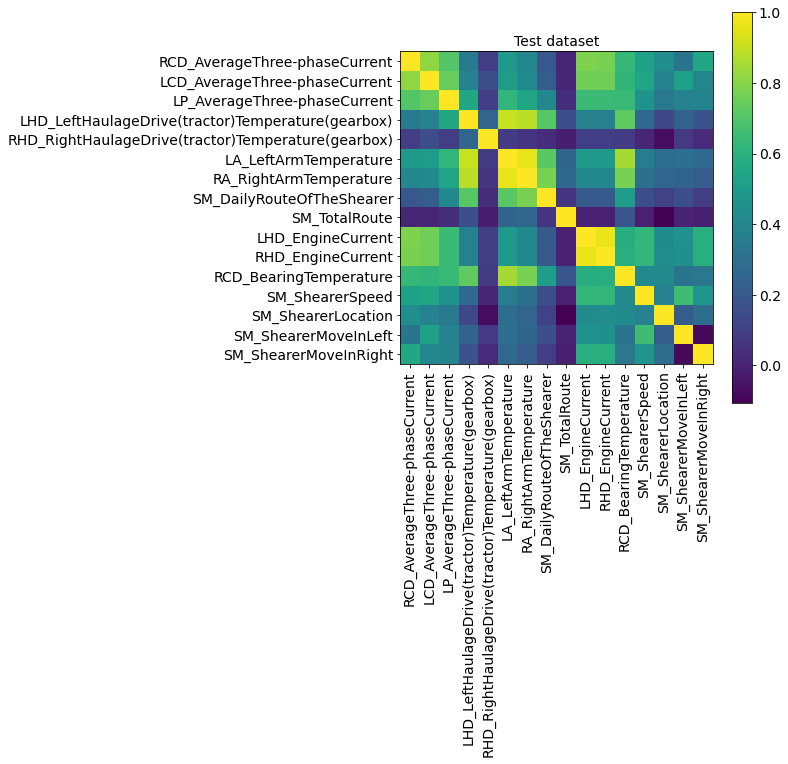

In [ ]:
show_heatmap(df_test, plot_title = "Test dataset", figsize=(7,7))

In [ ]:
import seaborn as sns

In [ ]:
from scipy.stats import kruskal

In [ ]:
kruskal(df_test["RCD_BearingTemperature"],df_validation["RCD_BearingTemperature"])

KruskalResult(statistic=11000.344092139208, pvalue=0.0)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AttributeError: module 'seaborn' has no attribute 'plt'

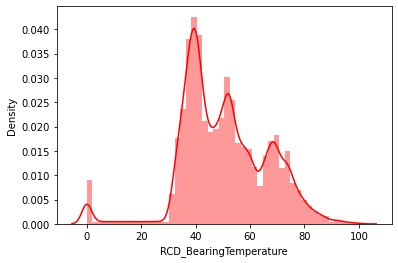

In [ ]:

sns.distplot( df_test["RCD_BearingTemperature"] , color="red", label="Sepal Width")
sns.plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RCD_BearingTemperature', ylabel='Density'>

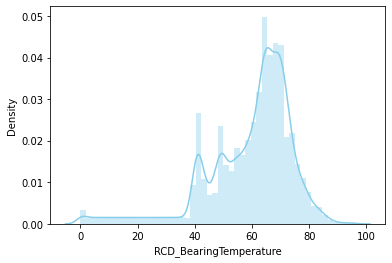

In [ ]:
sns.distplot( df_validation["RCD_BearingTemperature"] , color="skyblue", label="Sepal Length")


In [ ]:
df_train.columns

Index(['RCD_AverageThree-phaseCurrent', 'LCD_AverageThree-phaseCurrent',
       'LP_AverageThree-phaseCurrent',
       'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
       'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
       'LA_LeftArmTemperature', 'RA_RightArmTemperature',
       'SM_DailyRouteOfTheShearer', 'SM_TotalRoute', 'LHD_EngineCurrent',
       'RHD_EngineCurrent', 'RCD_BearingTemperature', 'SM_ShearerSpeed',
       'SM_ShearerLocation', 'SM_ShearerMoveInLeft', 'SM_ShearerMoveInRight'],
      dtype='object')

Mean and std of non-normalized artifacts

In [ ]:
df_validation_artifact = ds_validation_artifact.to_df()
df_test_artifact= ds_test_artifact.to_df()

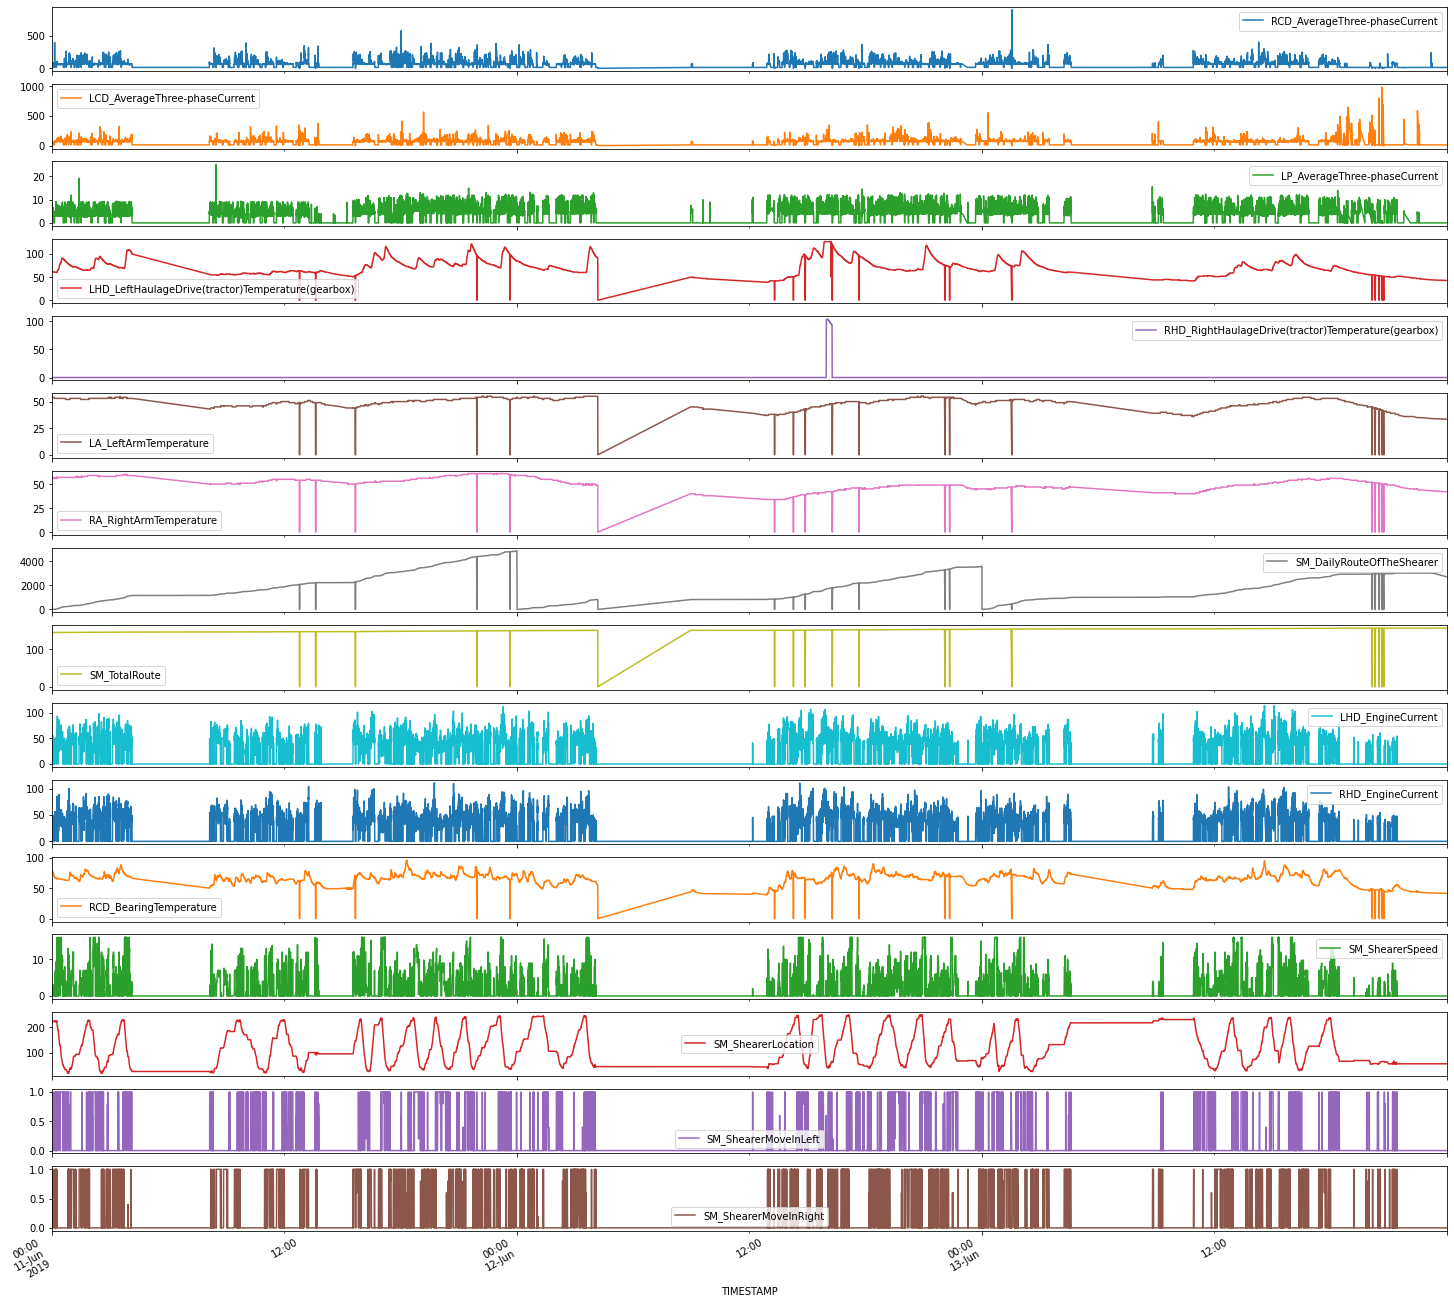

In [ ]:
plot_TS(df_validation_artifact,figsize=(25,25))

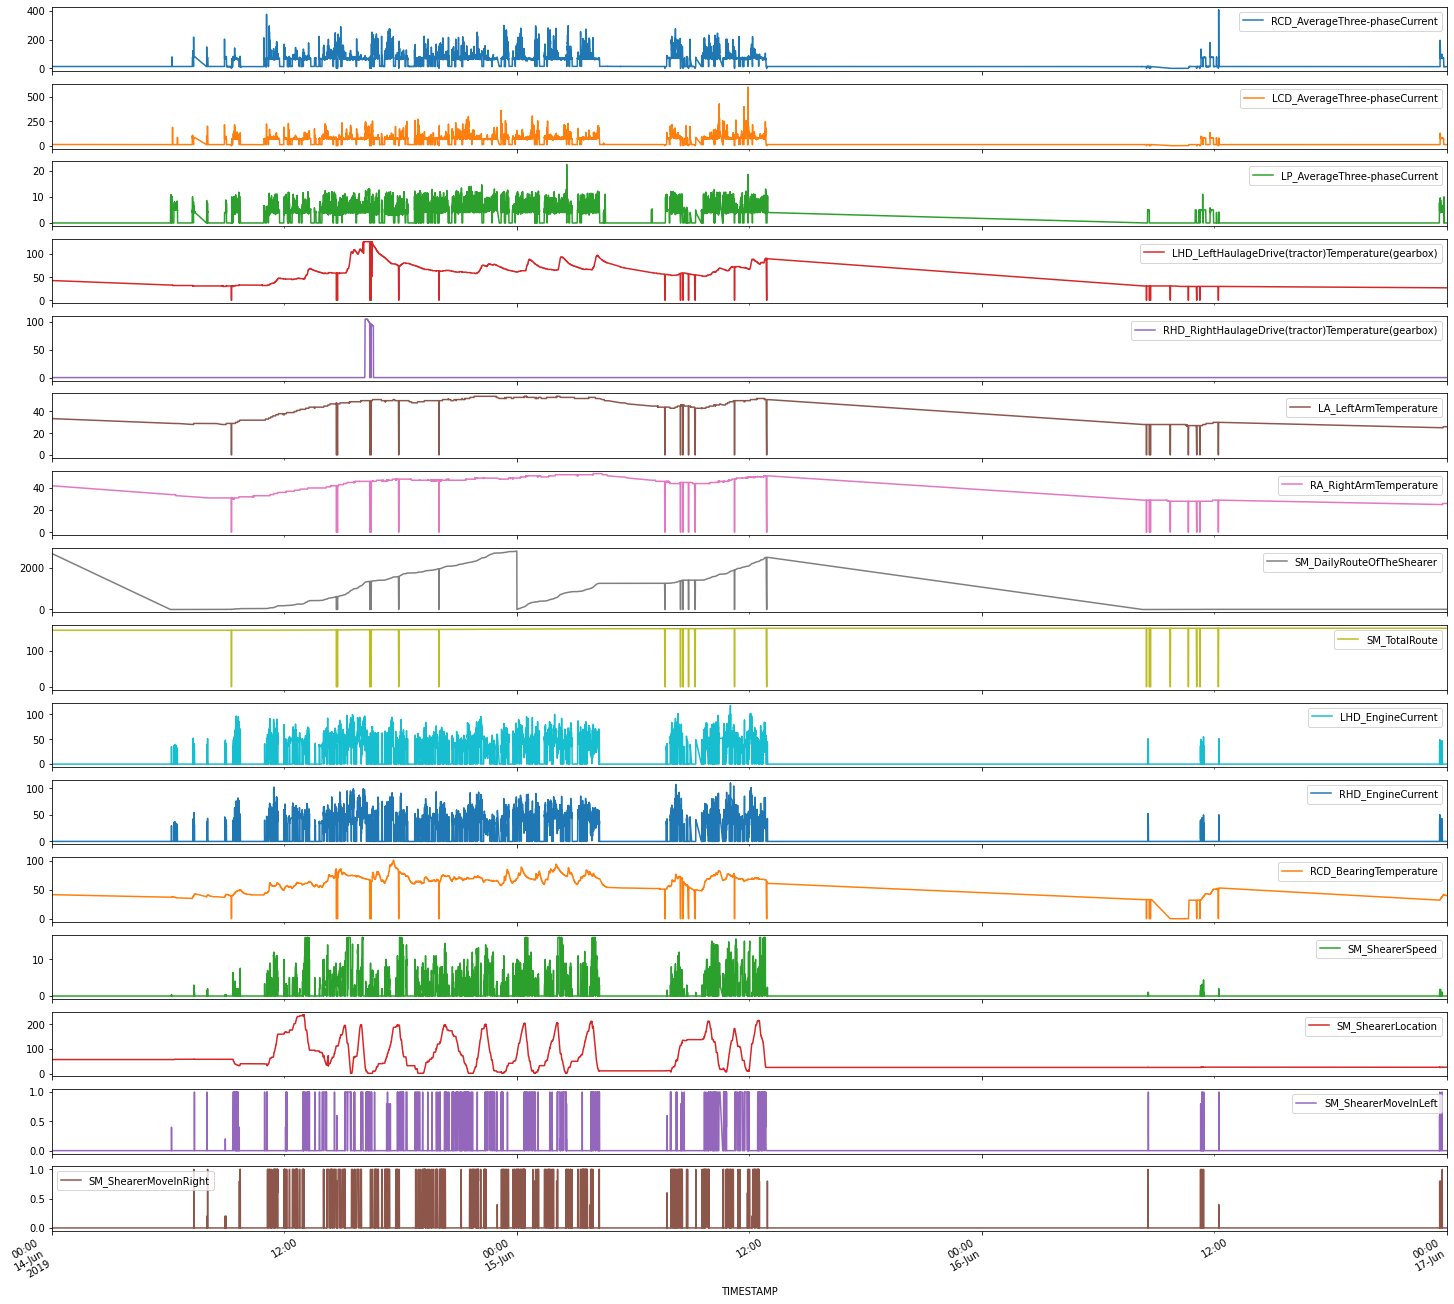

In [ ]:
plot_TS(df_test_artifact,figsize=(25,25))

In [ ]:
stats_test = df_test_artifact.agg([np.mean, np.std]).T
stats_validation = df_validation_artifact.agg([np.mean, np.std]).T


<AxesSubplot:title={'center':'plot'}>

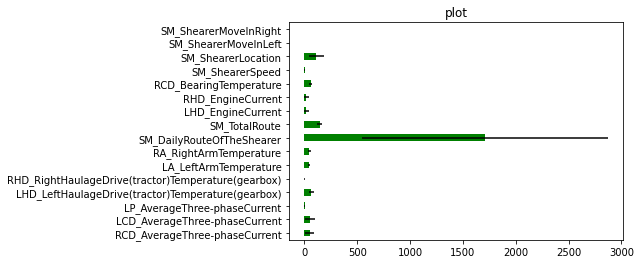

In [ ]:
stats_validation.plot(kind = "barh", y = "mean", legend = False,  
          xerr = "std", title = "plot", color='green')

<AxesSubplot:title={'center':'plot'}>

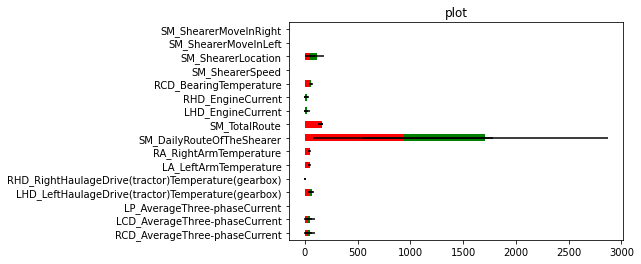

In [ ]:
ax = stats_validation.plot(kind = "barh", y = "mean", legend = False,  
          xerr = "std", title = "plot", color='green')
stats_test.plot(ax=ax,kind = "barh", y = "mean", legend = False,  
          xerr = "std", title = "plot", color='red' )

In [ ]:
fig = plt.figure()

for frame in [stats_validation, newdf2, newdf3, newdf4, newdf5]:
    plt.plot(frame['Time'], frame['Data'])

plt.xlim(0,18000)
plt.ylim(0,30)
plt.show()

Transform to pandas dataframe

In [ ]:
df_train_artifact = ds_train_artifact.to_df()
df_validation_artifact_norm = normalize_artifact(ds_validation_artifact, ds_train_artifact)
df_test_artifact_norm = normalize_artifact(ds_test_artifact, ds_train_artifact)

Artifacts are compatible.
Artifacts are compatible.


In [ ]:
stats_train = df_train_artifact.agg([np.mean, np.std]).T
stats_validation_norm = df_validation_artifact_norm.agg([np.mean, np.std]).T
stats_test_norm = df_test_artifact_norm.agg([np.mean, np.std]).T


<AxesSubplot:>

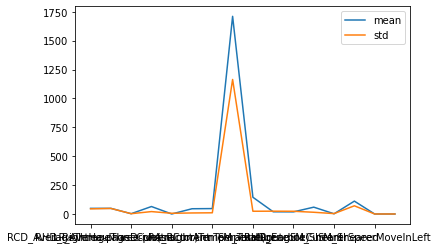

In [ ]:
stats_validation.plot()